In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import time
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Cleanup

In [ ]:
df = pd.read_csv('calories.csv')
df

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...,...
14995,15644082,female,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,17212577,female,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,17271188,female,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,18643037,male,78,193.0,97.0,2.0,84.0,38.3,11.0


In [ ]:
df = pd.read_csv('calories.csv')
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})
df.drop(['User_ID'], axis=1, inplace=True)
df

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,68,190.0,94.0,29.0,105.0,40.8,231.0
1,1,20,166.0,60.0,14.0,94.0,40.3,66.0
2,0,69,179.0,79.0,5.0,88.0,38.7,26.0
3,1,34,179.0,71.0,13.0,100.0,40.5,71.0
4,1,27,154.0,58.0,10.0,81.0,39.8,35.0
...,...,...,...,...,...,...,...,...
14995,1,20,193.0,86.0,11.0,92.0,40.4,45.0
14996,1,27,165.0,65.0,6.0,85.0,39.2,23.0
14997,1,43,159.0,58.0,16.0,90.0,40.1,75.0
14998,0,78,193.0,97.0,2.0,84.0,38.3,11.0


# Neural Network



In [ ]:
#@title Helper Functions (from Dr. Gordon Berman's QTM 385 class)
from matplotlib import animation, rc
rc('animation', html='jshtml')
from IPython.display import HTML
from keras.callbacks import Callback
import matplotlib.gridspec as gridspec

class SaveWeights(Callback):
    def __init__(self, interval=1):
        self.interval = interval

    def on_train_begin(self, logs=None):
        self.weights = []
        self.weights.append([w.numpy()+w.numpy().min() for w in self.model.weights if 'bias' not in w.name])

    def on_epoch_end(self, epoch, logs=None):
        if epoch%self.interval == 0:
            self.weights.append([w.numpy()+w.numpy().min() for w in self.model.weights if 'bias' not in w.name])

    def on_train_end(self, batch, logs=None):
        n_Weights = len(self.weights[0])
        fig, axes = plt.subplots(1, n_Weights, figsize=(1.5*n_Weights,5))
        axes = axes.flatten()
        ims = []
        for i in range(n_Weights):
            ax = axes[i]
            ax.set_title(r'$W_%i$'%(i+1))

        for t in range(len(self.weights)):
            ims_t = []
            for i in range(n_Weights):
                ax = axes[i]
                weights = self.weights[t]
                w = weights[i]
                w = np.atleast_2d(w)
                if w.shape[1] == 1:
                    w = w.T
                im = ax.imshow(w, cmap='Greys', animated=True)
                ims_t.append(im)
            ims.append(ims_t)
        self.anim = animation.ArtistAnimation(fig, ims, interval=33, blit=True,
                                              repeat_delay=1000)
        pass
    def animate(self):
      return self.anim


def plot_training_history(hist):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(hist.history['loss'], label='Training Loss', color='firebrick')
    ax.plot(hist.history['val_loss'], label='Validation Loss', color='royalblue')
    ax.legend(loc='center right')
    ax.set_ylabel("loss")
    ax.set_xlabel("Epoch #")
    if 'val_mae' in hist.history.keys():
        ax2 = ax.twinx()
        ax2.plot(hist.history['mae'], '--', label='Training Inaccuracy (via MAE)', color='firebrick', )
        ax2.plot(hist.history['val_mae'], '--', label='Testing Inaccuracy (via MAE)', color='royalblue')
        ax2.legend(loc='lower left')
        ax2.set_ylabel("mean absolute error")
weights_list = SaveWeights()

In [ ]:
#importing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
#defining X and y
X = df.drop(['Calories'], axis=1)
y = df['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define the model
model = keras.Sequential([
    Dense(7, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 7 neurons
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    Dense(64, activation='relu'),  # Hidden layer with 32 neurons
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    Dense(16, activation='relu'), # Hidden layer with 16 neurons
    Dense(1)  # Output layer (no activation function is used for regression!)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae']) # Use mean squared error for regression

# Train the model
calories_ann = model.fit(X_train, y_train, epochs=50, batch_size=200, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error: {mae}")


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 11169.3516 - mae: 85.7087 - val_loss: 3808.6147 - val_mae: 51.7368
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3491.7271 - mae: 49.8785 - val_loss: 3085.1614 - val_mae: 47.1920
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2629.1882 - mae: 43.2565 - val_loss: 1618.4047 - val_mae: 32.0274
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1203.0681 - mae: 26.7940 - val_loss: 434.4512 - val_mae: 15.3896
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 285.9045 - mae: 12.4034 - val_loss: 152.4043 - val_mae: 9.2021
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 145.9815 - mae: 8.9815 - val_loss: 133.8488 - val_mae: 8.6779
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 132.4387 - mae: 8.6178 - val_loss: 133.5929 - val_mae: 8.5307
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 120.4230 - mae: 8.2183 - val_loss: 122.5376 - val_mae: 8.2375
Epoch 9/50
60/60 ━━━━━━

**Plotting training history to evaluate if model trained properly** (bc its confusing to look at all the numbers lol, this uses the helper function at the start!)

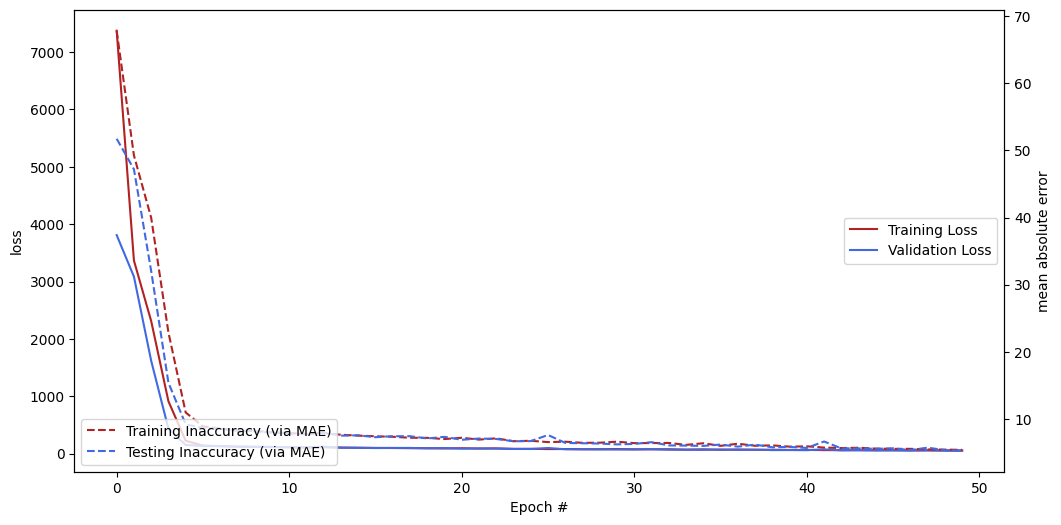

In [ ]:
plot_training_history(calories_ann)

**Evaluate Predictions**

In [ ]:
# Make predictions from our model
calories_pred = model.predict(X_test)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
# Calculate accuracy (example using R-squared)
r2 = r2_score(y_test, calories_pred)
print(f"R-squared (R2) Accuracy: {r2}")

R-squared (R2) Accuracy: 0.9871436856735898


In [ ]:
#calculating MSE
mse = mean_squared_error(y_test, calories_pred)
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 51.88540378844457


In [ ]:
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 5.2735981941223145


#Support Vector Machine for Regression

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load  data
df = pd.read_csv('calories.csv')
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})
df.drop(['User_ID'], axis=1, inplace=True)
X = df.drop(['Calories'], axis=1)
y = df['Calories']

# Preprocess data
categorical_features = ['Gender']
numeric_features = X.drop(columns=categorical_features).columns.tolist()
preprocessor = ColumnTransformer(
    [
        ("num", MinMaxScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

X_processed = preprocessor.fit_transform(X)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(np.array(y).reshape(-1, 1))


# Conduct Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_scaled, test_size=0.2, random_state=42
)

# Param Grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'epsilon': [0.1, 0.2]
}

# Create and train the model, using the radial basis function which finds higher dimensions via inner product calculation
svr = SVR(kernel='rbf')
grid_search = GridSearchCV(svr, param_grid, cv=2, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train.ravel())

# Predict and evaluate
best_svr = grid_search.best_estimator_
y_pred_scaled = best_svr.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = y_scaler.inverse_transform(y_test)

mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared: {r2:.4f}")